In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from collections import Counter


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

In [3]:
animal_classes = ["bear", "beaver", "chimpanzee", "fox", "kangaroo", "lion", "otter", "porcupine", "raccoon", "wolf"]
class_to_idx = {cls: dataset.class_to_idx[cls] for cls in animal_classes}

filtered_indices = [i for i, label in enumerate(dataset.targets) if label in class_to_idx.values()]
filtered_dataset = Subset(dataset, filtered_indices)

dataloader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

In [4]:
sample_image, _ = filtered_dataset[0]

print(sample_image.size())

torch.Size([3, 32, 32])


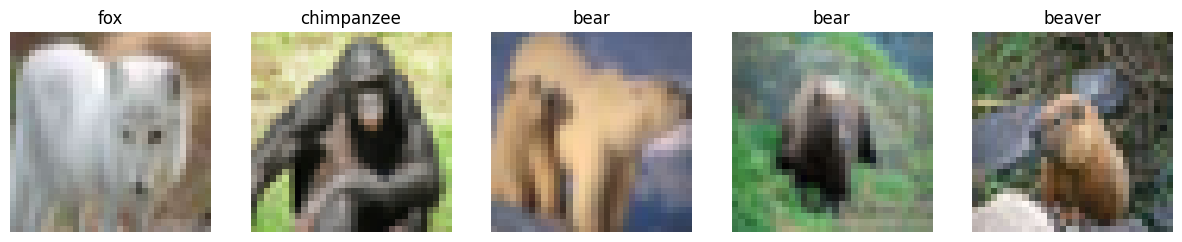

In [5]:
images, labels = next(iter(dataloader))

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Перетворюємо тензор у зображення
    axes[i].imshow(np.clip(img, 0, 1))  # Робимо корекцію кольорів
    axes[i].set_title(list(class_to_idx.keys())[list(class_to_idx.values()).index(labels[i].item())])
    axes[i].axis("off")

plt.show()

In [6]:
filtered_labels = [dataset.targets[i] for i in filtered_indices]

idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
filtered_class_names = [idx_to_class[label] for label in filtered_labels]

class_counts = Counter(filtered_class_names)

classes = list(class_counts.keys())
counts = list(class_counts.values())

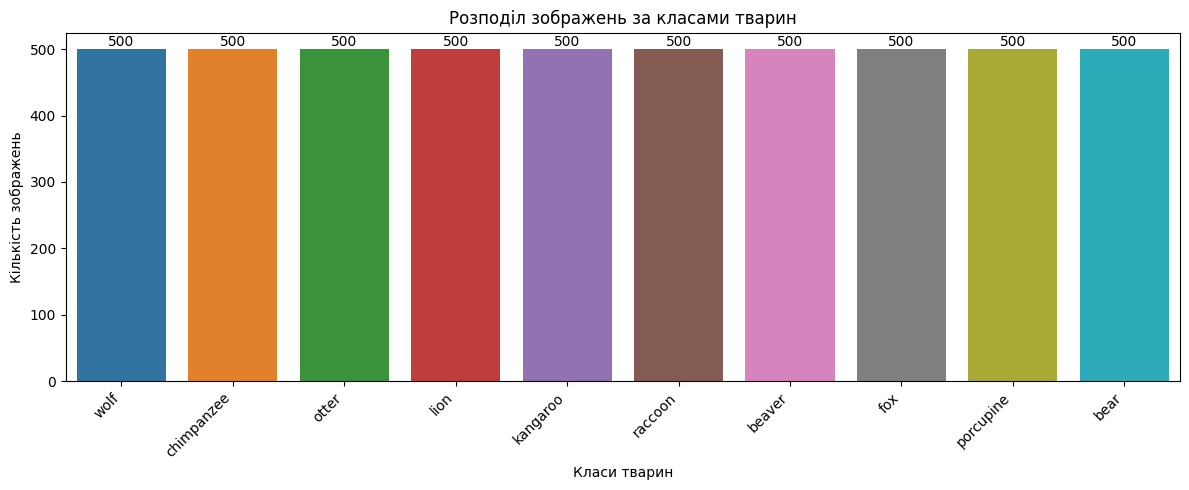

In [7]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=classes, y=counts, hue=classes)
ax.set_xlabel('Класи тварин')
ax.set_ylabel('Кількість зображень')
ax.set_title('Розподіл зображень за класами тварин')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(counts):
    ax.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

In [8]:
class_means = {}
class_stds = {}

for class_idx in class_to_idx.values():
    indices = np.where(np.array(dataset.targets) == class_idx)[0]
    class_imgs = []
    
    for idx in indices:
        img, _ = dataset[idx]
        class_imgs.append(img.numpy())
    
    class_imgs_array = np.array(class_imgs)
    class_means[class_idx] = np.mean(class_imgs_array, axis=0)
    class_stds[class_idx] = np.std(class_imgs_array, axis=0)

mean_imgs = [class_means[idx] for idx in class_to_idx.values()]


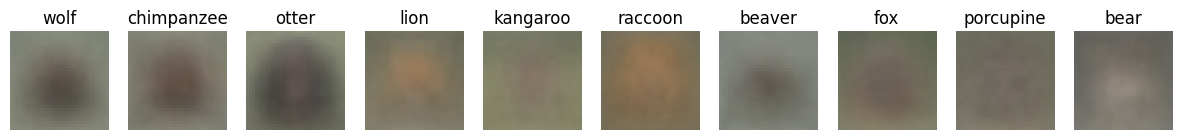

In [9]:
# Mean images
fig, axes = plt.subplots(1, len(mean_imgs), figsize=(15, 5))
for ax, mean_img, label in zip(axes, mean_imgs, classes):
    ax.imshow(np.transpose(mean_img, (1, 2, 0)), cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.show()

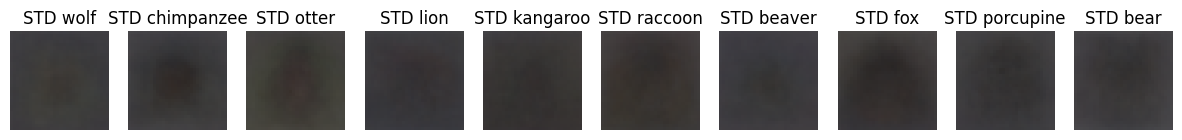

In [10]:
# STD images
fig, axes = plt.subplots(1, len(mean_imgs), figsize=(15, 5))
for ax, std_img, label in zip(axes, class_stds.values(), classes):
    ax.imshow(np.transpose(std_img, (1, 2, 0)), cmap='gray')
    ax.set_title(f'STD {label}')
    ax.axis('off')

plt.show()

In [11]:
channel_means = {}
channel_stds = {}

for class_idx in class_to_idx.values():
    indices = np.where(np.array(dataset.targets) == class_idx)[0]
    r_vals, g_vals, b_vals = [], [], []
    
    for idx in indices:
        img, _ = dataset[idx]
        r_vals.append(img[0].mean().item())  # Середнє значення червоного каналу
        g_vals.append(img[1].mean().item())  # Середнє значення зеленого каналу
        b_vals.append(img[2].mean().item())  # Середнє значення синього каналу
    
    channel_means[idx_to_class[class_idx]] = {
        'r': np.mean(r_vals),
        'g': np.mean(g_vals),
        'b': np.mean(b_vals)
    }
    
    channel_stds[idx_to_class[class_idx]] = {
        'r': np.std(r_vals),
        'g': np.std(g_vals),
        'b': np.std(b_vals)
    }

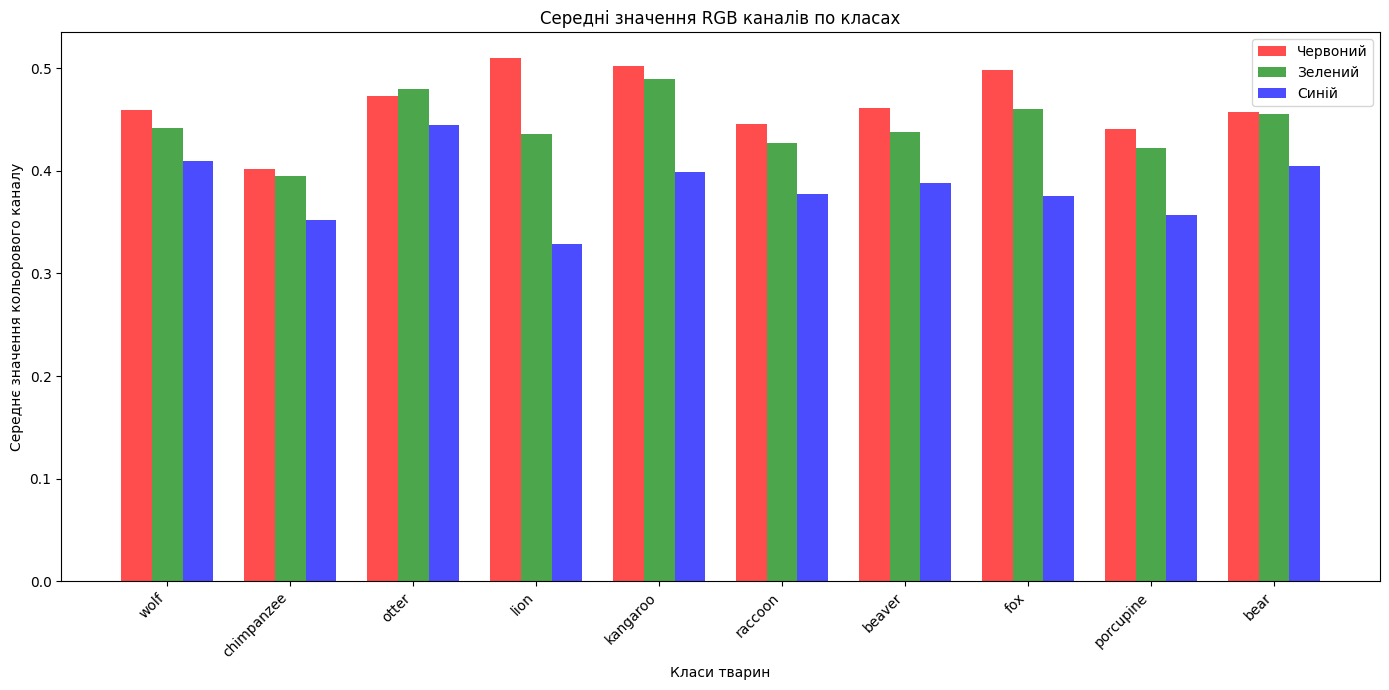

In [12]:
# Mean channel values
fig, ax = plt.subplots(figsize=(14, 7))
width = 0.25
x = np.arange(len(classes))

r_means = [channel_means[cls]['r'] for cls in classes]
g_means = [channel_means[cls]['g'] for cls in classes]
b_means = [channel_means[cls]['b'] for cls in classes]

ax.bar(x - width, r_means, width, label='Червоний', color='r', alpha=0.7)
ax.bar(x, g_means, width, label='Зелений', color='g', alpha=0.7)
ax.bar(x + width, b_means, width, label='Синій', color='b', alpha=0.7)

ax.set_xlabel('Класи тварин')
ax.set_ylabel('Середнє значення кольорового каналу')
ax.set_title('Середні значення RGB каналів по класах')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
brightness_means = {}
brightness_stds = {}

for class_idx in class_to_idx.values():
    indices = np.where(np.array(dataset.targets) == class_idx)[0]
    brightness_vals = []
    
    for idx in indices:
        img, _ = dataset[idx]
        # Яскравість як середнє значення всіх трьох каналів
        brightness = img.mean().item()
        brightness_vals.append(brightness)
    
    brightness_means[idx_to_class[class_idx]] = np.mean(brightness_vals)
    brightness_stds[idx_to_class[class_idx]] = np.std(brightness_vals)

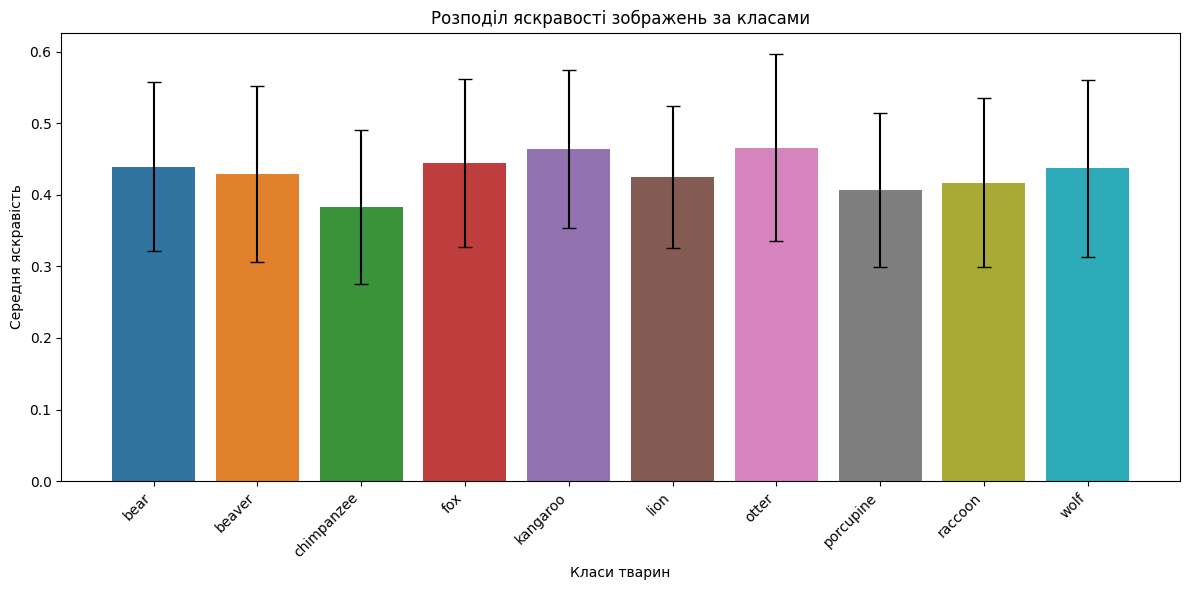

In [14]:
# Brightness distribution
plt.figure(figsize=(12, 6))
classes = list(brightness_means.keys())
brightness_values = list(brightness_means.values())
error_bars = list(brightness_stds.values())

sns.barplot(x = classes, y = brightness_values, hue=classes)
plt.errorbar(x=classes, y=brightness_values, yerr=error_bars, fmt='none', c='black', capsize=5)
plt.xlabel('Класи тварин')
plt.ylabel('Середня яскравість')
plt.title('Розподіл яскравості зображень за класами')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()